## GRAPPA Student Seminar 2019
# Week 1 - Script
### by *The Sterile Neutrinos* group

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import root
from scipy.special import zeta
from astropy import constants as C
from astropy import units
from astropy.cosmology import Planck15 as cosmo
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = plt.rcParams['axes.labelsize'] = plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

We will be working in mass units, so define some constants in $\mathrm{GeV}$ (that's not even a mass unit, btw...):

In [2]:
Mp = (np.sqrt(C.hbar*C.c/(8*np.pi*C.G)) * C.c**2).to(units.GeV)
T0 = (C.k_B * cosmo.Tcmb0).to(units.GeV)
rho0 = (cosmo.critical_density0 * C.hbar**3 * C.c**5).to(units.GeV**4)

Define the grid of masses and cross-sections that we will be calculating the abundance for. These are logarithmically spaced.

In [3]:
m_edges = np.linspace(-12, 3, 201) 
sigma_edges = np.linspace(-12, -6, 201) 
m = np.power(10, 0.5*(m_edges[1:]+m_edges[:-1])) * units.GeV
sigma = np.power(10, 0.5*(sigma_edges[1:]+sigma_edges[:-1])) * units.GeV**(-2)
g = 1

def plot(Odm, medges=None, sigmaedges=None, vmin=None, vmax=None):
    medges = np.power(10, m_edges if medges is None else medges)
    sigmaedges = np.power(10, sigma_edges if sigmaedges is None else sigmaedges)
    
    fig, ax = plt.subplots()
    pcm = ax.pcolormesh(medges, sigmaedges, Odm,
                        cmap='jet',
                        norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('$m$')
    ax.set_ylabel(r'$\left\langle{\sigma v}\right\rangle_{fo}, \mathrm{GeV}^{-2}$')
    ax.set_xlim(1e-12, 1e3)
    ax.xaxis.set_ticks((1e-12, 1e-9, 1e-6, 1e-3, 1, 1e3))
    ax.xaxis.set_ticklabels((r'$\mathrm{meV}$', r'$\mathrm{eV}$', r'$\mathrm{keV}$', r'$\mathrm{MeV}$', r'$\mathrm{GeV}$', r'$\mathrm{TeV}$'))
    cax = plt.colorbar(pcm)
    cax.set_label(r'$\Omega_{\mathrm{DM}, 0}$', rotation=-90, verticalalignment='bottom')
    return fig, ax, cax

### Part 1: Instantaneous freeze-out

#### a. Relativistic (hot) dark matter

The number density of a relativistic species is given by
$$n = \frac{\zeta(3)}{\pi^2} g T^3,$$
where $\zeta(3) \approx 1.202$ is Apéry's constant, and $g$ is its number of degrees of freedom (including a factor of $3/4$ for a fermionic species). We will combine the constants into a single number and write $n=\mathcal{N}T^3$. Because of the simple $T^3$ dependence of the number density, relativistic species redshift in the same way regardless of whether they are in thermal equilibrium ($n \propto T^3$), or not ($n \propto a^{-3} \propto T_{\gamma}^3$, with $T_\gamma$ the photon temperature), and so we can simply estimate their present number density as $n = \mathcal{N} T_0^3$. Therefore, their present-day abundance is simply
$$\Omega_{\textrm{HDM}, 0} = \frac{n m}{\rho_c} = \frac{\zeta(3)}{\pi^2} \frac{T_0^3}{\rho_c} gm.$$
Note that it does not depend on the reaction cross-section since, as mentioned, it does not matter whether the DM particles react (are in thermal equilibrium) or not. Also note that $T_0$ is *their* present temperature. In calculations, though, we will be using the CMB (photon) temperature. A difference between the two can be present if another species remained in equilibrium with the photons after the dark matter decoupled and subsequently annihilated (as in the case of $e^+/e^-$, which led to a factor $11/4$ increase in $T_\gamma^3$ post-neutrino decoupling due to the electron-positron annihilation heat).

Text(0.5, 1.0, 'Hot dark matter model')

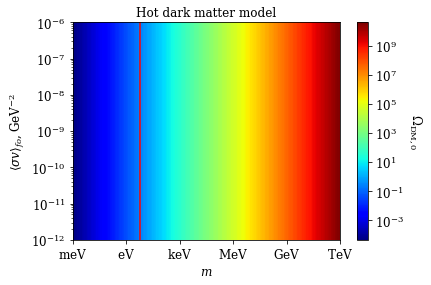

In [4]:
Ohdm0 = ((zeta(3)/np.pi**2) * (T0**3 / rho0) * g * m).to('').value
fig, ax, cax = plot(np.broadcast_to(Ohdm0, np.broadcast(m[None, :], sigma[:, None]).shape))
ax.vlines((cosmo.Odm0 * (np.pi**2 / zeta(3)) * (rho0 / T0**3) / g).to('GeV').value,  
          np.power(10, sigma_edges[0]), np.power(10, sigma_edges[-1]), colors='r')
ax.set_title('Hot dark matter model')

The red line in the above plot indicates the mass that fits the Planck 2015 result of $\Omega_{\textrm{DM}, 0} = 0.26$.

#### b. Non-relativistic (cold) dark matter

For a non-relativistic (cold: $m>T$) species, the number density derives from the classical Maxwell-Boltzmann distribution:
$$n = g \left(\frac{mT}{2\pi}\right)^{3/2} \textrm{e}^{-m/T}.$$
Here $g$ is the number of classical degrees of freedom (no additional factors for spin statistics). Equating the reaction rate that results from such a number density $\Gamma = n\sigma v$ to the Hubble parameter $H = T^2 / M_p$ at the time of decoupling (freeze-out):
$$n_{fo} \left\langle\sigma v\right\rangle_{fo} = \frac{T_{fo}^2}{M_p} \quad\implies\quad n_{fo} = g \left(\frac{mT_{fo}}{2\pi}\right)^{3/2} \textrm{e}^{-m/T} = \frac{T_{fo}^2}{M_p \left\langle\sigma v\right\rangle_{fo}},$$
which can be rearranged and expressed in terms of the dimensionless variable $x\equiv m/T$:
$$\sqrt{x_{fo}}\textrm{e}^{-x_{fo}} = \frac{\left(2\pi\right)^{3/2}}{g} \frac{1}{M_p m \left\langle\sigma v\right\rangle_{fo}} \equiv A.$$
This transcendental equation can be solved numerically for all values $A < 1/\sqrt{2\textrm{e}}$ of the right-hand-side. In fact, there are two solutions: one smaller and one larger than $x=1/2$, corresponding to the location of the maximum of the LHS. Furthermore, we are interested only in the case of a cold particle for which $x>1$, so we further restrict the possible values to $A<1/\textrm{e}$.

Once we have $x_{fo}$, we can calculate the present-day abundance using the formula from the lecture notes
$$\Omega_{\textrm{CDM}, 0} = \frac{T_0^3}{\rho_c M_p} \frac{x_{fo}}{\left\langle\sigma v\right\rangle_{fo}}.$$

In [5]:
A = (((2*np.pi)**(3/2) / g) / (Mp * m[None, :] * sigma[:, None])).to('').value

def solve_x_fo(a):
    return np.nan if a > np.exp(-1) else root(lambda x: np.sqrt(x)*np.exp(-x)-a, 1).x

x_fo = np.vectorize(solve_x_fo)(A)
Ocdm0 = (T0**3 / (rho0 * Mp)) * x_fo / sigma[:, None]

/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


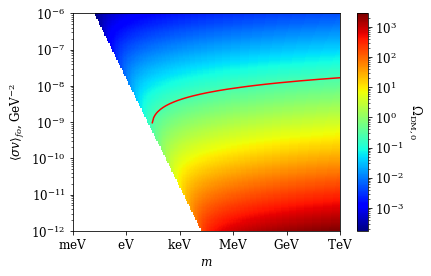

In [6]:
fig, ax, cax = plot(Ocdm0.value)

good = []
diff = Ocdm0 - cosmo.Odm0
diff[np.isnan(diff)] = np.inf
initial_guesses = sigma[np.nanargmin(np.abs(diff), axis=0)]
for i in range(Ocdm0.shape[1]):
    ipol = interp1d(sigma, Ocdm0[:, i], kind='linear', bounds_error=False)
    res = root(lambda x: ipol(x) - cosmo.Odm0, initial_guesses[i])
    good.append(res.x[0] if res.success else np.nan)
ax.plot(m.value, good, 'r-')

In the plot above the blank area is the region where $A>1/\textrm{e}$, while the red line again connects parametes that give $\Omega_{\textrm{DM}, 0} = 0.26$.

From $A \propto \sqrt{x_{fo}} \text{e}^{-x_{fo}}$, and considering that $\sqrt{x_{fo}}$ remains roughly constant for $x_{fo}$ in the range $[20, 50]$ (varies by a factor of $\approx 1.5$), we have that for a constant $\sigma$,
$$x_{fo} \propto \ln{m} \quad\implies\quad \Omega_{\text{CDM}, 0} \propto x_{fo} \propto \ln{m}.$$

Similarly, for a constant $m$,
$$x_{fo} \propto \ln{\sigma} \quad\implies\quad \Omega_{\text{CDM}, 0} \propto \frac{x_{fo}}{\sigma} \propto \frac{\ln{\sigma}}{\sigma} \propto \sigma^{-1}$$ since the logarithm varies much more slowly over the range we are considering.

Here is a quick plot to illustrate the two scalings:

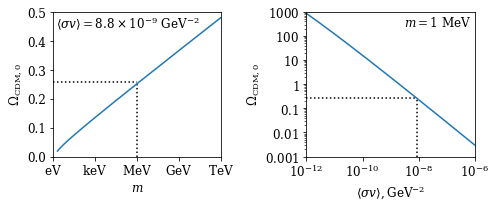

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

ax[0].semilogx(m, Ocdm0[131, :].to('').value)
ax[0].text(0.02, 0.98, r'$\left\langle\sigma v\right\rangle = 8.8\times10^{-9}\ \mathrm{GeV}^{-2}$', fontsize=12,
           transform=ax[0].transAxes, verticalalignment='top')
ax[0].set_ylabel(r'$\Omega_{\mathrm{CDM}, 0}$')
ax[0].set_xlabel('$m$')
ax[0].xaxis.set_ticks((1e-9, 1e-6, 1e-3, 1, 1e3))
ax[0].xaxis.set_ticklabels((r'$\mathrm{eV}$', r'$\mathrm{keV}$', r'$\mathrm{MeV}$', r'$\mathrm{GeV}$', r'$\mathrm{TeV}$'))
ax[0].set_ylim(0, 0.5)
ax[0].set_xlim(1e-9, 1e3)
ax[0].vlines(1e-3, ax[0].get_ylim()[0], cosmo.Odm0, linestyles=':')
ax[0].hlines(cosmo.Odm0, ax[0].get_xlim()[0], 1e-3, linestyles=':')

ax[1].loglog(sigma, Ocdm0[:, 120])
ax[1].text(0.98, 0.98, r'$m = 1\ \mathrm{MeV}$', fontsize=12,
          transform=ax[1].transAxes, verticalalignment='top', horizontalalignment='right')
ax[1].set_ylabel(r'$\Omega_{\mathrm{CDM}, 0}$')
ax[1].set_xlabel(r'$\left\langle\sigma v\right\rangle, \mathrm{GeV}^{-2}$')
ax[1].set_xlim(0.5e-12, 2e-6)
ax[1].set_xticks(np.power(10., np.arange(-12, -5, 2)))
ax[1].yaxis.set_ticks((1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3))
ax[1].yaxis.set_ticklabels(('$0.001$', '$0.01$', '$0.1$', '$1$', '$10$', '$100$', '$1000$'))
ax[1].set_xlim(1e-12, 1e-6)
ax[1].set_ylim(1e-3, 1e3)
ax[1].vlines(sigma[131].value, ax[1].get_ylim()[0], cosmo.Odm0, linestyles=':')
ax[1].hlines(cosmo.Odm0, ax[1].get_xlim()[0], sigma[131].value, linestyles=':')
fig.tight_layout()

### Part 2: Gradual cold dark matter freeze-out


We wish to solve the Riccati equation
\begin{align}
    \frac{\textrm{d}Y}{\textrm{d}x} = \frac{s \left\langle\sigma v\right\rangle}{Hx} \left[1 + \frac{1}{3}\frac{\textrm{d}\ln{g_s}}{\textrm{d}\ln{T}}\right] \left[Y_{\textrm{eq}}^2 - Y^2\right]
    & = \left(M_p \left\langle\sigma v\right\rangle m\right) \frac{s}{m^3} x \left[\left(\frac{n_{\textrm{eq}}}{m^3} \frac{m^3}{s}\right)^2 - Y^2\right] \left|\left[1 + \frac{1}{3}\frac{\textrm{d}\ln{g_s}}{\textrm{d}\ln{T}}\right]\right|_{T=m/x}
    \\ & \textrm{with} \qquad \frac{s}{m^3} = \frac{2\pi^2}{45} \frac{g_s}{x^3}
    \qquad \textrm{and} \qquad \frac{n_{\textrm{eq}}}{m^3} = \frac{g}{\left(2\pi\right)^{3/2}} \frac{\textrm{e}^{-x}}{x^{3/2}}
\end{align}
subject to the initial condition $Y(x=1) = Y_{\textrm{eq}}(x=1)$. Instead, however, for greatly improved numerical performance, we will solve for $\textrm{d}\ln{Y} / \textrm{d}\ln{x}$ by introducing an additional factor $x/Y$ to the RHS. For the dependence $g_s(T)$ we will use figure 2 from [Steigman et al. 2012](https://arxiv.org/abs/1204.3622).

First, we define the various components of the equations, loading the $g_s(T)$ data from file and setting interpolators to give the required derivative.

In [7]:
def neq_overm3(x, g=1):
    return (g / (2 * np.pi * x)**(3/2)) * np.exp(-x)
def s_overm3(x, gs):
    return (2*np.pi**2/45) * gs / x**3
def Yeq(x, gs, g=1):
    return neq_overm3(x, g) / s_overm3(x, gs)

T_data, gsm_data = np.loadtxt('week_1_g.csv', delimiter=',', unpack=True)
gsm = interp1d(T_data*units.GeV, gsm_data, fill_value='extrapolate')

Tmid_data = (T_data[:-1]+T_data[1:])/2
lngsmderiv_data = np.diff(np.log(gsm_data)) / np.diff(np.log(T_data))
lngsmderiv = interp1d(Tmid_data*units.GeV, lngsmderiv_data, fill_value='extrapolate')

def Riccati(x, y, mGeV, B, g=1):
    s = s_overm3(x, gsm(mGeV/x))
    return B * s * x * ((neq_overm3(x, g)/s)**2 - y**2) * (1 + lngsmderiv(mGeV/x) / 3)

Then we partially reproduce figure 1 from the paper by solving the evolution $Y(x)$ for $m=100\ \textrm{GeV}$ and three cross-sections corresponding to weak, EM and strong interactions.

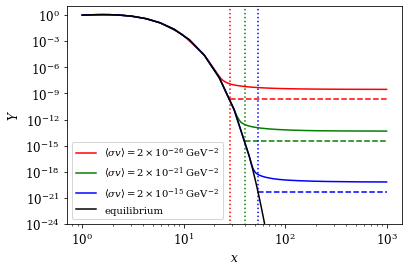

In [8]:
log10xmax = 3

m1 = 100*units.GeV
yi = Yeq(1, gsm(m1))

for sexp, clr in zip((-26, -21, -15), ('r', 'g', 'b')):
    sigma1 = 2*10**sexp * (units.cm**3/units.s)/C.c
    sigma1 = (sigma1/(C.hbar*C.c)**2).to(units.GeV**(-2))
    sol = solve_ivp(lambda logx, logy:
                        Riccati(np.exp(logx), np.exp(logy),
                                m1, Mp*m1*sigma1)
                        * np.exp(logx-logy),
                    (0, log10xmax*np.log(10)), [np.log(yi)],
                    method='BDF')
    x, y = np.exp(sol.t), np.exp(sol.y[0]) / yi
    l, = plt.loglog(x, y, clr,
                    label=r'$\left\langle\sigma v\right\rangle = 2\times10^{'+str(sexp)+'}\ \mathrm{GeV}^{-2}$')
    x_fo = solve_x_fo(1/(Mp*m1*sigma1))
    y_fo = Yeq(x_fo, gsm(m1 / x_fo)) / yi
    plt.vlines(x_fo, 1e-25, 1e5,
               colors=l.get_color(), linestyles=':')
    plt.hlines(y_fo, x_fo, np.power(10, log10xmax),
               colors=l.get_color(), linestyles='--')
plt.loglog(x, Yeq(x, gsm(m1/x)) / yi, 'k', label='equilibrium')
plt.ylim(1e-24, 1e1)
plt.xlabel('$x$')
plt.ylabel('$Y$')
plt.legend(loc='lower left')

#### Bonus: Residual abundance
Now we will calculate the residual (at $x=1000$) dark matter density $Y$ for the grid of masses and cross-sections from Part 1. This takes a lot of time, so we will only run it once and save the result in `week_1_exact.npz`...

In [9]:
m_edges_rare = np.linspace(-12, 3, 201)
sigma_edges_rare = np.linspace(-12, -6, 201)
m_rare = np.power(10, 0.5*(m_edges_rare[1:]+m_edges_rare[:-1])) * units.GeV
sigma_rare = np.power(10, 0.5*(sigma_edges_rare[1:]+sigma_edges_rare[:-1])) * units.GeV**(-2)

@np.vectorize
def solve_y0(m, B, yi, log10xmax):
    if np.isnan(solve_x_fo(((2*np.pi)**(3/2) / g) / B)):
        return np.nan
    else:
        sol = solve_ivp(lambda logx, logy:
                            Riccati(np.exp(logx), np.exp(logy),
                                    m, B)
                            * np.exp(logx-logy),
                        (0, log10xmax*np.log(10)), [np.log(yi)],
                        method='BDF')
        return np.exp(sol.y[0][-1])

if False:  # Set to True to run
    %time y0 = solve_y0(m_rare.to(units.GeV).value[None, :], (Mp*m_rare[None, :]*sigma_rare[:, None]).to('').value, Yeq(1, gsm(m_rare)), log10xmax)
    np.savez_compressed('week_1_exact.npz', y0=y0, m_edges_rare=m_edges_rare, sigma_edges_rare=sigma_edges_rare)

... and then load and plot it:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


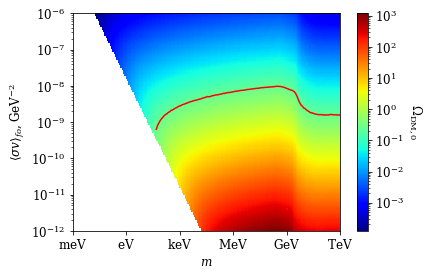

In [10]:
file = np.load('week_1_exact.npz')
m_edges_rare, sigma_edges_rare, y0 = file['m_edges_rare'], file['sigma_edges_rare'], file['y0']
m_rare = np.power(10, 0.5*(m_edges_rare[1:]+m_edges_rare[:-1])) * units.GeV
sigma_rare = np.power(10, 0.5*(sigma_edges_rare[1:]+sigma_edges_rare[:-1])) * units.GeV**(-2)

Ocdm0_exact = (s_overm3(m_rare/T0, gsm(T0)) * m_rare**4 * y0/rho0).to('').value
fig, ax, cax = plot(Ocdm0_exact, m_edges_rare, sigma_edges_rare)

good = []
diff = Ocdm0_exact - cosmo.Odm0
diff[np.isnan(diff)] = np.inf
initial_guesses = sigma_rare[np.nanargmin(np.abs(diff), axis=0)]
for i in range(Ocdm0_exact.shape[1]):
    ipol = interp1d(sigma_rare, Ocdm0_exact[:, i], kind='linear', bounds_error=False, fill_value='extrapolate')
    res = root(lambda x: ipol(x) - cosmo.Odm0, initial_guesses[i], tol=0.01)
    good.append(res.x[0] if res.success else np.nan)
ax.plot(m_rare.value, np.where(np.array(good) > 0, good, np.nan), 'r-')

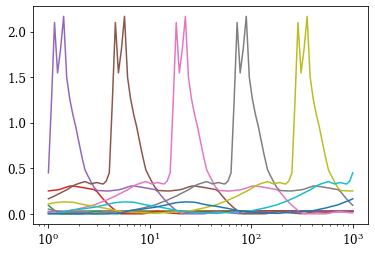

In [11]:
for m1 in np.logspace(-3, 3, 11) * units.GeV:
    plt.semilogx(np.logspace(0, 3, 101), lngsmderiv(m1/np.logspace(0, 3, 101)))